In [1]:
import cPickle
import random
import time
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import MDS


def load_movie_dict():
    start = time.time()
    with open(r"tmdb_info.pickle", "rb") as input_file:
        movie_dict = cPickle.load(input_file)
    elapsed = time.time() - start
    print "load: %.1f secs" % elapsed
    return movie_dict

    
movie_dict = load_movie_dict()
print len(movie_dict)

load: 5.1 secs
31486


1000
(1000, 383)


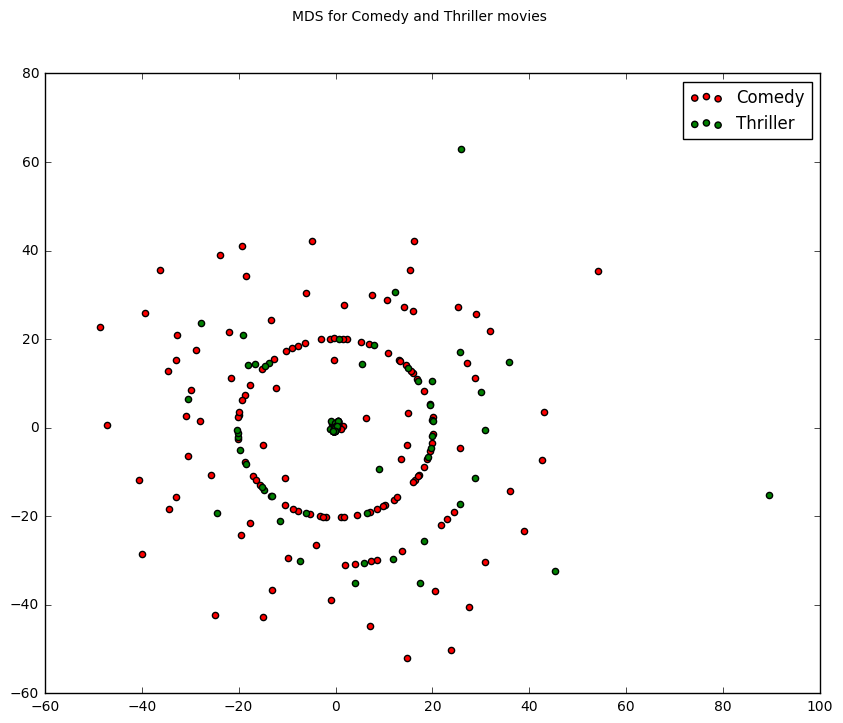

In [4]:
def get_movie_attribute_name_list(movie_dict):
    attr_set = set()
    for movie in movie_dict.itervalues():
        attr_set |= set(movie.__dict__.keys())
    return list(attr_set)


def get_movie_df(movie_dict):
    all_movie_attribute_name_list = [
        # 'poster_path', 'backdrop_path', 'base_uri', 'id', 'imdb_id',
        # 'genres',

        'production_countries', 'overview', 'video',
        'title', 'tagline', 'crew', 'homepage',
        'belongs_to_collection', 'original_language', 'status', 'spoken_languages',
        'adult', 'production_companies',
        'original_title',

        'revenue', 'vote_count', 'release_date', 'popularity', 'budget', 'vote_average', 'runtime', 'cast',
    ]
    movie_attribute_name_list = [
        'revenue',
        'vote_count',
        'popularity',
        'budget',
        'vote_average',
        'cast',
        'genres',
        # 'release_date',
        # 'runtime',
    ]

    movie_attribute_dict = defaultdict(list)
    for movie in movie_dict.itervalues():
        for movie_attribute_name in movie_attribute_name_list:
            attr_list = movie_attribute_dict[movie_attribute_name]
            attr_list.append(getattr(movie, movie_attribute_name))

    return pd.DataFrame(movie_attribute_dict)


def explore_pca(movie_df):
    # print movie_df.describe()

    scaled_movies = preprocessing.scale(movie_df)

    pca = PCA(n_components=2)
    pca_X = pca.fit_transform(scaled_movies)

    print "explained variance ratio:"
    print pca.explained_variance_ratio_

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_X[:, 0], pca_X[:, 1])
    plt.show()


def prepare_cast(movie_df):
    cast_list = [cast_member['name'] for movie_cast_list in movie_df['cast'] for cast_member in movie_cast_list]
    cast_counter = Counter(cast_list)

    appearances_limit = 2
    included_cast_list = [cast_name for cast_name, num_movies in cast_counter.iteritems()
                          if num_movies >= appearances_limit]
    included_cast_set = set(included_cast_list)

    num_movies = len(movie_df)
    print num_movies
    movie_attribute_dict = defaultdict(lambda: np.zeros((num_movies,), dtype=np.uint8))

    for i, movie_cast_list in enumerate(movie_df['cast']):
        for cast_member in movie_cast_list:
            cast_name = cast_member['name']
            if cast_name in included_cast_set:
                movie_attribute_dict['cast_' + cast_name][i] = 1

    new_movie_df = movie_df.drop("cast", axis=1)

    for key, column in movie_attribute_dict.iteritems():
        new_movie_df[key] = column

    print new_movie_df.shape
    return new_movie_df


def prepare_columns(movie_df):
    return prepare_cast(movie_df)


def get_one_genre_name(movie_genres):
    one_genre = "Other"
    for genre in movie_genres:
        genre_name = genre['name']
        if genre_name == 'Comedy' or genre_name == 'Thriller':
            one_genre = genre_name
            break
    return one_genre


def convert_genres(genres):
    return [get_one_genre_name(movie_genres) for movie_genres in genres]


def explore_mds(movie_df):
    scaled_movies = preprocessing.scale(movie_df.drop('genres', axis=1))
    genres = movie_df['genres']
    genre_labels = np.array(convert_genres(genres))

    # print genre_labels

    mds = MDS(n_components=2, verbose=1, n_jobs=1, max_iter=120)
    mds_X = mds.fit_transform(scaled_movies)

    plt.figure(figsize=(10, 8))
    comedy_indices = genre_labels == 'Comedy'
    thriller_indices = genre_labels == 'Thriller'
    plt.scatter(mds_X[comedy_indices, 0], mds_X[comedy_indices, 1], c='r', label='Comedy')
    plt.scatter(mds_X[thriller_indices, 0], mds_X[thriller_indices, 1], c='g', label='Thriller')
    plt.legend()
    plt.suptitle("MDS for Comedy and Thriller movies")
    plt.show()


def get_subsample(movie_df):
    random.seed(109)
    return movie_df.loc[np.random.choice(movie_df.index, 1000, replace=False)]


movie_df = get_movie_df(movie_dict)

movie_df = get_subsample(movie_df)

movie_df = prepare_columns(movie_df)

# explore_pca(movie_df)

explore_mds(movie_df)
